### Installation and imports

In [31]:
from typing import Optional
from IPython.display import display, HTML, SVG

# Install Indigo toolkit for cheminformatics
!pip install epam.indigo -q

# Confirm the version of Indigo installed
!pip show epam.indigo
# If !pip install indigo is run, a different tool is installed.
# the correct tool should show as follows:
    # Name: epam.indigo
    # Version: 1.13.0
    # Summary: Indigo universal cheminformatics toolkit
    # Home-page: https://lifescience.opensource.epam.com/indigo/index.html
    # Author: EPAM Systems Life Science Department
    # Author-email: lifescience.opensource@epam.com
    # License: Apache-2.0
    # Location: /usr/local/lib/python3.10/dist-packages
    # Requires:
    # Required-by:

# Import and initialize Indigo and its components
from indigo import Indigo
indigo = Indigo()
from indigo.renderer import IndigoRenderer
renderer = IndigoRenderer(indigo)


Name: epam.indigo
Version: 1.19.0
Summary: Indigo universal cheminformatics toolkit
Home-page: https://lifescience.opensource.epam.com/indigo/index.html
Author: EPAM Systems Life Science Department
Author-email: lifescience.opensource@epam.com
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 


### Indigo Rendering Utility

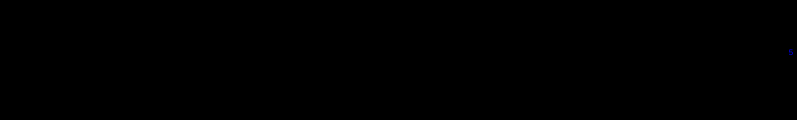

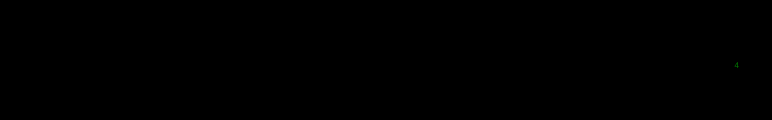

In [32]:
import os
import uuid
from IPython.display import SVG, Image, display

def create_image(smiles: str,
                 is_reaction: bool = True,
                 display_image: bool = True,
                 write_to_file: bool = False,
                 file_path: str = '',
                 image_format: str = 'svg',
                 numbering_option: str = 'none') -> None:
    loader = indigo.loadReactionSmarts if is_reaction else indigo.loadSmarts
    entity = loader(smiles)

    # Set rendering options
    indigo.setOption("render-output-format", image_format)
    indigo.setOption("render-implicit-hydrogens-visible", False)
    indigo.setOption("embedding-uniqueness", "none")
    indigo.setOption("render-bond-length", 40)

    # Reset atom and bond IDs visibility
    indigo.setOption("render-atom-ids-visible", False)
    indigo.setOption("render-bond-ids-visible", False)

    # Set numbering options according to the user's request
    if 'atom_maps' in numbering_option:
        indigo.setOption("render-atom-ids-visible", True)  # This shows atom mapping numbers
    if 'bond_indices' in numbering_option:
        indigo.setOption("render-bond-ids-visible", True)  # This shows bond indices

    entity.aromatize()

    if is_reaction:
        entity.correctReactingCenters()

    # Handle file path for display or writing
    if display_image and not file_path:
        file_path = f"/tmp/{uuid.uuid4()}.{image_format}"
        write_to_file = True  # Force file writing for display purposes

    if write_to_file:
        renderer.renderToFile(entity, file_path)

    if display_image:
        if image_format == 'svg':
            display(SVG(filename=file_path))
        elif image_format == 'png':
            display(Image(filename=file_path))

        if not write_to_file:
            os.remove(file_path)  # Clean up the file if it was only needed for display

# Example usage:
mapped_rxn = "[#6:1](-[#6:2](=[#8:3])-[#8:4]-[#6:5](-[H:10])(-[H:11])-[H:12])(-[H:7])(-[H:8])-[H:9].[#8:6](-[H:13])-[H]>>[#6:1](-[#6:2](=[#8:3])-[#8:6]-[H:13])(-[H:7])(-[H:8])-[H:9].[#6:5](-[#8:4]-[H])(-[H:10])(-[H:11])-[H:12]"
create_image(mapped_rxn, is_reaction=True, display_image=True, write_to_file=False, numbering_option='atom_maps')
create_image(mapped_rxn, is_reaction=True, display_image=True, write_to_file=False, numbering_option='bond_indices')

### Extractor Function

In [33]:
from indigo import Indigo

def extract_evodex(mapped_rxn: str):
    indigo = Indigo()
    rxn = indigo.loadReactionSmarts(mapped_rxn)
    rxn.correctReactingCenters()

    def find_changed_bonds(rxn):
        changed_bonds = []
        for mol_idx, mol in enumerate(rxn.iterateMolecules()):
            for bond in mol.iterateBonds():
                if rxn.reactingCenter(bond) & indigo.RC_MADE_OR_BROKEN:
                    changed_bonds.append((mol_idx, bond.index()))
        return changed_bonds

    changed_bonds_info = find_changed_bonds(rxn)
    print(f"Changed Bonds: {len(changed_bonds_info)}")

    def fragment_molecule(mol, bond_index):
        mol_clone = mol.clone()
        # Use removeBonds with a list containing the bond index
        mol_clone.removeBonds([bond_index])
        fragments = mol_clone.iterateComponents()
        return [frag.clone() for frag in fragments]

    reactant_fragments = []
    product_fragments = []

    for mol_idx, bond_index in changed_bonds_info:
        mol = rxn.getMolecule(mol_idx)
        fragments = fragment_molecule(mol, bond_index)
        if mol_idx < rxn.countReactants():
            reactant_fragments.extend(fragments)
        else:
            product_fragments.extend(fragments)

    reactant_smirks = [frag.smiles() for frag in reactant_fragments]
    product_smirks = [frag.smiles() for frag in product_fragments]

    return rxn, changed_bonds_info, reactant_smirks, product_smirks



### Testing on one example

Changed Bonds: 4
Changed Bonds: [(0, 2), (1, 1), (2, 2), (3, 1)]
Reactant Fragments: ['C([H])([H])([H])C=O', 'OC([H])([H])[H]', 'O[H]', '[H]']
Product Fragments: ['C([H])([H])([H])C=O', 'O[H]', 'C([H])([H])([H])O', '[H]']


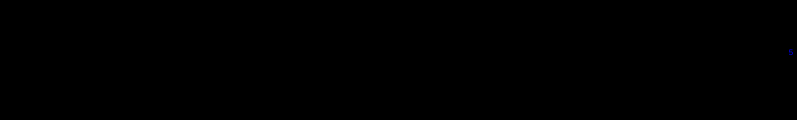

In [34]:
mapped_rxn = "[#6:1](-[#6:2](=[#8:3])-[#8:4]-[#6:5](-[H:10])(-[H:11])-[H:12])(-[H:7])(-[H:8])-[H:9].[#8:6](-[H:13])-[H]>>[#6:1](-[#6:2](=[#8:3])-[#8:6]-[H:13])(-[H:7])(-[H:8])-[H:9].[#6:5](-[#8:4]-[H])(-[H:10])(-[H:11])-[H:12]"
rxn, changed_bonds, reactant_fragments, product_fragments = extract_evodex(mapped_rxn)
print("Changed Bonds:", changed_bonds)
print("Reactant Fragments:", reactant_fragments)
print("Product Fragments:", product_fragments)
create_image(mapped_rxn, is_reaction=True, display_image=True, write_to_file=False, numbering_option='atom_maps')

Reactant Fragments:
Fragment 1:


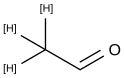

Fragment 2:


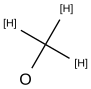

Fragment 3:


Fragment 4:


Product Fragments:
Fragment 1:


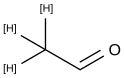

Fragment 2:


Fragment 3:


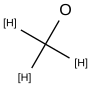

Fragment 4:


In [35]:
def display_fragments(fragments, is_reaction=False):
    for idx, fragment_smiles in enumerate(fragments):
        print(f"Fragment {idx + 1}:")
        create_image(fragment_smiles, is_reaction=is_reaction, display_image=True, write_to_file=False, image_format='svg', numbering_option='none')

# Assuming you have lists `reactant_fragments` and `product_fragments` containing SMILES strings for each fragment
print("Reactant Fragments:")
display_fragments(reactant_fragments, is_reaction=False)

print("Product Fragments:")
display_fragments(product_fragments, is_reaction=False)
